        E:\Data\FinalResults\Dsp\0848 - Quantification of Topology is already existed!
[[1. 7.]]
[[1. 2.]]
[[1. 4.]]
[[1. 4.]]
[[1. 2.]]
[[1. 1.]]
[[1. 2.]]
[[1. 0.]]
[[1. 3.]]
[[1. 3.]]
[[2. 7.]]
[[1. 5.]]
[[ 1. 11.]]
[[1. 3.]]
[[1. 1.]]
[[1. 1.]]
[[1. 1.]]
[[1. 4.]]
[[1. 1.]]
[[1. 4.]]
[[1. 6.]]
[[1. 2.]]
[[ 2. 10.]]
[[ 2. 15.]]
[[ 1. 11.]]
[[ 5. 12.]]
[[ 3. 27.]]
[[ 2. 39.]]
(56,)


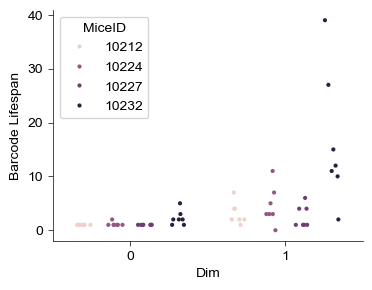

  Mean: 1.3571428571428572, STD: 0.8541614816500999, Max: 5.0, Min: 1.0, Median: 1.0, df: 27
  Mean: 6.714285714285714, STD: 8.387308196048968, Max: 39.0, Min: 0.0, Median: 4.0, df: 27


In [ ]:
from mylib.statistic_test import *
from sklearn.decomposition import PCA
from ripser import ripser
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mazepy.basic._time_sync import _coordinate_recording_time

dir_name = r"E:\Data\FinalResults\Dsp\0844 - Manifold of Initialization"
code_id = "0848 - Quantification of Topology"
loc = os.path.join(figpath, 'Dsp', code_id)
mkdir(loc)

n_perm = 1200
filtration_thresh = np.inf
metric = "cosine"

def get_neural_traj(trace: dict, is_shuffle=False):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    route_trajs = []
    lap_trajs = []
    map_trajs = []
    speed_trajs = []

    for i in range(beg_idx.shape[0]):
        if trace['is_perfect'][i] != 1:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        if is_shuffle:
            for j in range(Spikes.shape[0]):
                Spikes[j, :] = np.roll(Spikes[j, :], np.random.randint(Spikes.shape[1]))
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        time_traj = neural_traj.time
         
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        dx, dy = np.ediff1d(trace['correct_pos'][:, 0]), np.ediff1d(trace['correct_pos'][:, 1])
        dt = np.ediff1d(trace['correct_time'])
        speed = np.sqrt(dx**2+dy**2) / dt * 100
        speed = np.convolve(speed, np.ones(3)/3, mode='same')
        idx = _coordinate_recording_time(time_traj.astype(np.float64), trace['correct_time'].astype(np.float64))
        speed_trajs.append(speed[idx])
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        map_trajs.append(np.repeat(trace['map_cluster'][i], neural_traj_vec.shape[1]))
    
    return np.concatenate(neural_trajs, axis=1), np.concatenate(pos_trajs), np.concatenate(route_trajs), np.concatenate(lap_trajs), np.concatenate(map_trajs), np.concatenate(speed_trajs)

def run_mouse(mouse: int, day: int = 0, is_shuffle: bool = False, n_crossvad: int = 10, is_two_map: bool = False):
    print(f"Mouse {mouse}, S{day+1} Starts ---------------------------------------------------")
    assert isinstance(mouse, int) and mouse in [10212, 10224, 10227, 10232] and day < 7
    
    with open(join(dir_name, f"{mouse}.pkl"), 'rb') as handle:
        _, session_traj, _, _, _, _, pos_traj, _, _, _, _, _, _, neural_traj = pickle.load(handle)
        idx = np.where(session_traj == day)[0]
        neural_traj = neural_traj[:, idx]
 

    if is_shuffle:
        print(f"  Shuffle Data By Random Rollings for Each Neuron.")
        for i in range(neural_traj.shape[0]):
            neural_traj[i, :] = np.roll(neural_traj[i, :], np.random.randint(neural_traj.shape[1]))

    if is_two_map:
        print(f"  Only Final Segment Is Considered.")
        bins = np.concatenate([
            Father2SonGraph[i] for i in CP_DSP[3]
        ])
        idx = np.where(np.isin(pos_traj+1, bins))[0]
        neural_traj = neural_traj[:, idx]

    pca = PCA(n_components=30, random_state=42)
    denoised_data = pca.fit_transform(neural_traj.T)
    denoised_data = denoised_data.astype(np.float16)

    # -------------------------------------
    # 1. Simulate High-Dimensional Data

    # -------------------------------------
    # 3. Construct UMAP's Fuzzy Topological Graph
    # -------------------------------------
    # Use UMAP to construct the fuzzy topological graph (step 1 of UMAP)
    # We don't reduce to 2D yet, as we want the intermediate structure
    umap_model = UMAP(n_neighbors=800, min_dist=0.1, n_components=3, metric=metric)
    umap_model.fit(denoised_data)
    del neural_traj, pca, denoised_data
    
    # Refer to 
    d: scipy.sparse.csr_matrix = umap_model.graph_  # This is the fuzzy topological graph (sparse matrix)
    d = (d + d.transpose() - d.multiply(d.transpose()))
    del umap_model
    d = -np.log(d.toarray().astype(np.float16))
    np.fill_diagonal(d, 0)
    
    # Use persistent cohomology (Ripser) on the graph
    t = time.time()
    print("Quantification of Topology Starts. It is time-consuming.")
    results = []
    for i in range(n_crossvad):
        print(f"    Iter {i+1}")
        result = ripser(d, maxdim=1, thresh=filtration_thresh, distance_matrix=True, metric=metric, n_perm=n_perm)  # Set thresh to control sparsity
    results.append(result)
    print(f"{time.time() - t:.2f} s used.")
    print(f"Metric: {metric}")
    print(f"Filtration Upper Bound: {filtration_thresh}")
    print("Finished.", end='\n\n')
    del d

    return results

def convert_barcode_to_lifespans(diagrams, max_dim=1):
    lifespans = []
    for dim in range(max_dim + 1):
        length = []
        for idx, (birth, death) in enumerate(diagrams[dim]):
            length.append(death - birth)
        lifespans.append(np.array(length, dtype=np.float64))
    return lifespans


if exists(join(figdata, f"{code_id} .pkl")) == False:
    Data = {
        "MiceID": [],
        "Training Day": [],
        "Barcode Lifespan": [],
        "Threshold": [],
        "Dim": [], # H0 or H1
        "Type": [], # Real or Shuffle
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        for day in range(7):
            with open(join(loc, f"{mouse}_S{day+1}.pkl"), 'rb') as handle:
                diagrams = pickle.load(handle)
            with open(join(loc, f"{mouse}_S{day+1}_shuffle.pkl"), 'rb') as handle:
                diagrams_shuf = pickle.load(handle)
            
            lifespans, lifespans_shuf = [], []
            
            print(len(diagrams), len(diagrams_shuf))
            for diag in diagrams_shuf:
                lifespans_shuf.append(convert_barcode_to_lifespans(diag['dgms'], max_dim=1))
            
            ls_shuf0 = np.concatenate([ls[0] for ls in lifespans_shuf])
            ls_shuf1 = np.concatenate([ls[1] for ls in lifespans_shuf])
            
            thres = (np.array([np.std(ls_shuf0[np.isinf(ls_shuf0)==False]), np.std(ls_shuf1[np.isinf(ls_shuf1)==False])])*5 
                     + np.array([np.mean(ls_shuf0[np.isinf(ls_shuf0)==False]), np.mean(ls_shuf1[np.isinf(ls_shuf1)==False])]))
            
            real_barcodes = np.zeros((len(diagrams), 2), dtype=np.float64)
            for i in range(len(diagrams)):
                ls = convert_barcode_to_lifespans(diagrams[i]['dgms'], max_dim=1)
                real_barcodes[i, 0] = np.where(ls[0] > thres[0])[0].shape[0]
                real_barcodes[i, 1] = np.where(ls[1] > thres[1])[0].shape[0]
                
            print(real_barcodes)
                
            real_barcodes = np.mean(real_barcodes, axis=0)
            
            Data["MiceID"].append(np.repeat(mouse, 2))
            Data["Training Day"].append(np.repeat(day, 2))
            Data["Barcode Lifespan"].append(real_barcodes)
            Data["Threshold"].append(thres)
            Data["Dim"].append(np.array([0, 1]))
            Data["Type"].append(np.array(["Real", "Shuffle"]))
                
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
    
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as handle:
        pickle.dump(Data, handle)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    
    print(Data["Dim"].shape)
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)


fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x="Dim",
    y="Barcode Lifespan",
    hue="MiceID",
    dodge=True,
    data=D,
    jitter=0.2,
    size=3,
    ax=ax
)
plt.show()

print_estimator(Data["Barcode Lifespan"][Data["Dim"] == 0])
print_estimator(Data["Barcode Lifespan"][Data["Dim"] == 1])

In [5]:

if exists(join(figdata, f"{code_id}.pkl")) == True:
"""
with open(r"E:\Data\FinalResults\Dsp\0844 - Manifold of Initialization\10232_res.pkl", 'wb') as handle:
    pickle.dump([diagrams, diagrams_shuf], handle) 
"""

#with open(r"E:\Data\FinalResults\Dsp\0844 - Manifold of Initialization\10232_res.pkl", 'rb') as handle:
#    diagrams, diagrams_shuf = pickle.load(handle) 

##############################################################################
# 3. Define a custom plotting function for barcodes in separate subplots
##############################################################################
def plot_barcodes_stacked(diagrams, max_dim=2, max_radius=None, shade=True, thres: list[float | None] = [None, None]):
    """
    Plots barcode diagrams in stacked subplots for H^0, H^1, ... up to max_dim.
    
    Parameters:
    -----------
    diagrams  : list of np.ndarray
        The list of persistence intervals as returned by ripser['dgms'].
    max_dim   : int
        Maximum homology dimension to plot (e.g., 2 means H^0, H^1, H^2).
    max_radius: float or None
        If None, the x-axis limit is automatically determined. Otherwise, use this for the x-axis max.
    shade     : bool
        Whether to add a light gray shaded region behind the bars (like in your example).
    """
    # Number of rows = (max_dim + 1) for dimensions: 0, 1, ..., max_dim
    fig, axes = plt.subplots(nrows=max_dim + 1, ncols=1, figsize=(4, 3 * (max_dim + 1)), sharex=True)
    # If there's only one dimension, make axes iterable
    if max_dim == 0:
        axes = [axes]
    
    # Determine a suitable x-axis limit if none given
    if max_radius is None:
        # Look at the largest death time across all dims
        all_deaths = []
        for dgm in diagrams[:max_dim+1]:
            finite_deaths = [pt[1] for pt in dgm if pt[1] < np.inf]
            all_deaths += finite_deaths
        if len(all_deaths) > 0:
            max_radius = max(all_deaths)
        else:
            max_radius = 1.0  # fallback
    
    # Plot each dimension in its own subplot
    for dim in range(max_dim + 1):
        print(f"Start Plot H{dim}.")
        ax = Clear_Axes(axes[dim], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
        dgm = diagrams[dim]  # intervals for this dimension
        # Sort intervals by length (not strictly necessary, but can look nicer)
        #dgm_sorted = sorted(dgm, key=lambda x: (x[1]-x[0]) if x[1] != np.inf else 9999, reverse=True)
        
        """
        dgm_shuf = shuf[dim]
        for idx, (birth, death) in enumerate(dgm_shuf):
            # If it's infinite, we can choose to plot up to max_radius or skip
            if death == np.inf:
                death = max_radius
            
            # y-level = idx
            ax.plot([birth, death], [idx, idx], color='gray', lw=2)
        """
        # Plot each interval as a horizontal line
        # We'll just stack them (y = index of interval)

        
        if thres[0] is not None:
            for idx, (birth, death) in enumerate(dgm):
                # If it's infinite, we can choose to plot up to max_radius or skip
                if death == np.inf:
                    death = max_radius
            
                # y-level = idx
                ax.plot([birth, birth+thres[dim]], [idx, idx], color='gray', lw=0.5)
                
        for idx, (birth, death) in enumerate(dgm):
            # If it's infinite, we can choose to plot up to max_radius or skip
            if death == np.inf:
                death = max_radius
            
            # y-level = idx
            ax.plot([birth, death], [idx, idx], color='green', lw=0.5)        
            
        # Set some labels and limits
        ax.set_xlim([0, max_radius])
        ax.set_ylim([-0.5, len(dgm) - 0.5])
        ax.set_ylabel(f"$H^{dim}$", rotation=0, labelpad=20, va='center')
    
    # Only label the bottom subplot for the x-axis
    axes[-1].set_xlabel("Radius")
    
    plt.suptitle("Stacked Barcode Diagram")
    plt.tight_layout()
    plt.show()

In [6]:
result_shufs = run_mouse(10232, day=6, is_shuffle=True)
#diagrams_shuf = result_shuf['dgms']
#plot_barcodes_stacked(diagrams_shuf, max_dim=1, max_radius=50, shade=True)
lifespans_shufs = [convert_barcode_to_lifespans(result_shuf['dgms'], max_dim=1) for result_shuf in result_shufs]
thres = np.array([[np.sort(lifespans_shuf[0])[-2], np.max(lifespans_shuf[1])] for lifespans_shuf in lifespans_shufs])
thres = np.max(thres, axis=0)

Mouse 10232 Starts ---------------------------------------------------
  Shuffle Data By Random Rollings for Each Neuron.
UMAP(angular_rp_forest=True, metric='cosine', n_components=3, n_neighbors=800, verbose=True)
Fri Jan 10 02:00:19 2025 Construct fuzzy simplicial set
Fri Jan 10 02:00:19 2025 Finding Nearest Neighbors
Fri Jan 10 02:00:19 2025 Building RP forest with 11 trees
Fri Jan 10 02:00:19 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Fri Jan 10 02:00:42 2025 Finished Nearest Neighbor Search
Fri Jan 10 02:00:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jan 10 02:00:57 2025 Finished embedding


C:\Users\12454\AppData\Local\Temp\ipykernel_30728\2106965598.py:107: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d.toarray().astype(np.float16))


Quantification of Topology Starts. It is time-consuming.
    Iter 1
    Iter 2
    Iter 3
    Iter 4
    Iter 5
    Iter 6
    Iter 7
    Iter 8
    Iter 9
    Iter 10
759.01 s used.
Metric: cosine
Filtration Upper Bound: inf
Finished.



[2.3828125, 1.8974609375]


Start Plot H0.
Start Plot H1.


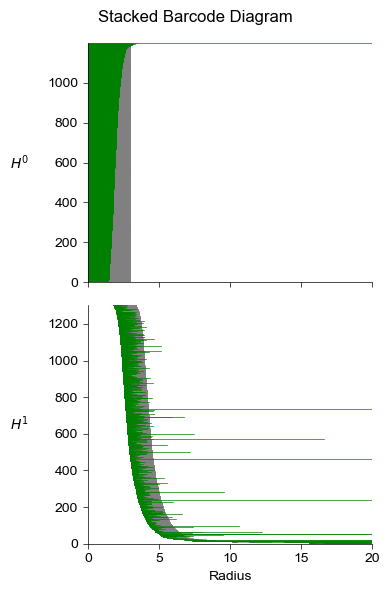

In [8]:
#result = run_mouse(10232, day=6, is_shuffle=False, n_crossvad=1)[0]
#diagrams = result['dgms']        # diagrams[0]: H^0; diagrams[1]: H^1; diagrams[2]: H^2
#lifespans = convert_barcode_to_lifespans(diagrams, max_dim=1)
plot_barcodes_stacked(diagrams, max_dim=1, max_radius=20, shade=True, thres=thres)